In [111]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 
import warnings
warnings.filterwarnings("ignore")

In [40]:
df = pd.read_csv("Daily_running_shoes.csv", index_col = "date")

In [51]:
test_size = 30
split_point = int(df.shape[0]-test_size)

In [52]:
df_train = df.iloc[0:split_point,:]
df_test = df.iloc[split_point:df.shape[0],:]

In [53]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [54]:
df_train.head()

,quantity
date,
2019-06-01,157
2019-06-02,7
2019-06-03,37
2019-06-04,2583
2019-06-05,2586


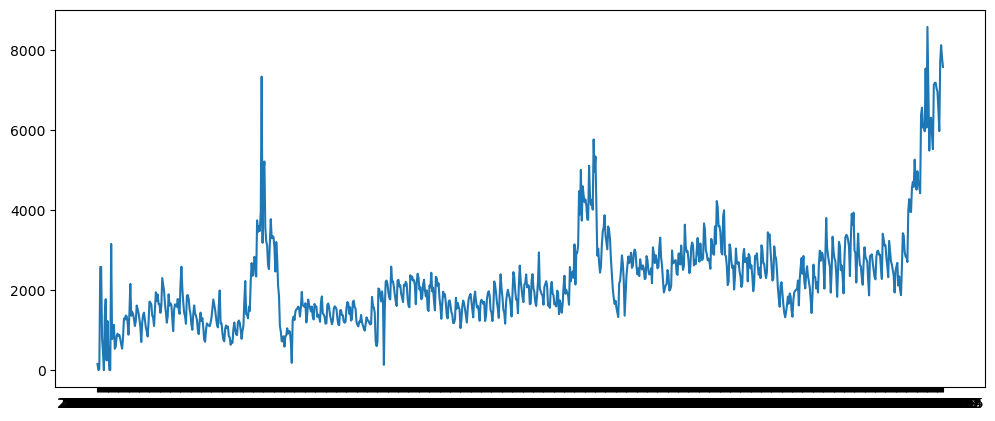

In [126]:
plt.figure(figsize=(12,5), dpi=100)
plt.locator_params(axis="x", nbins=12)
plt.plot(df_train)

plt.show()

In [57]:
def ADF_Stationarity_Test(timeseries, significance_level = 0.05):
    """
    Test if series is stationary given a time-series object and a seignificance level
    """
    X = timeseries.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1]<significance_level:
        print(f"Rejected null hypothesis at {round(significance_level,2)}% significance level. The test found evidence of stationarity")
    else:
        print(f"Failed to reject null hypothesis at {round(significance_level,2)}% significance level. No evidence of stationarity")

In [58]:
ADF_Stationarity_Test(df_train)

ADF Statistic: -1.438585
p-value: 0.563645
Failed to reject null hypothesis at 0.05% significance level. No evidence of stationarity


The test indicates it is not stationary, (sales increased over time). Let's check the difference with first lag.

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

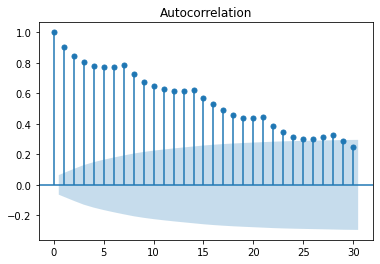

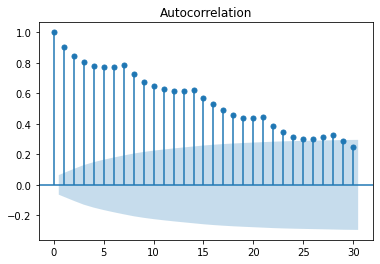

In [140]:
plot_acf(df_train) #in the raw series correlation up to the 28th lag

In [104]:
#Getting the difference series (t - (t-1))
X = df_train - df_train.shift(1)
X = X.dropna()

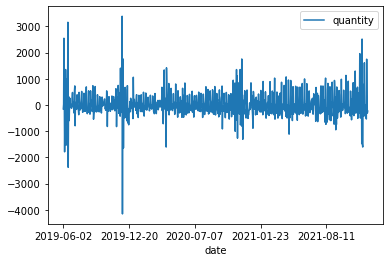

In [108]:
X.plot();

Looks much better and it seems to be stationary

In [106]:
ADF_Stationarity_Test(X)

ADF Statistic: -6.061285
p-value: 0.000000
Rejected null hypothesis at 0.05% significance level. The test found evidence of stationarity


Stationarity confirmed by the test

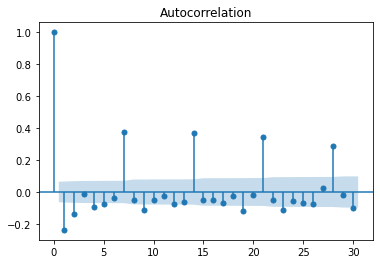

In [109]:
plot_acf(X)
plt.show()

When the difference to the 1st lag is applied autocorrelation seems to go up to the 2nd lag, so a AR(1) will be used with I(1)

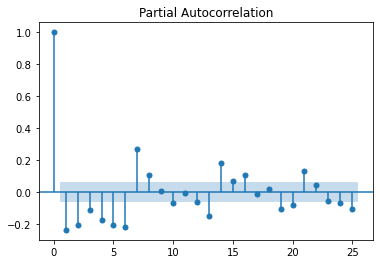

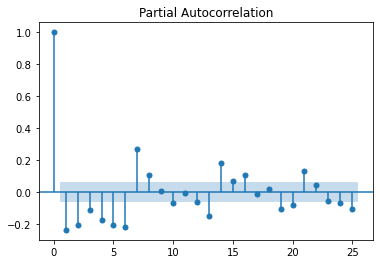

In [110]:
plot_pacf(X, lags=25)

The pacf plot suggests the MA(8). 
We will start with ARIMA(2,1,8).

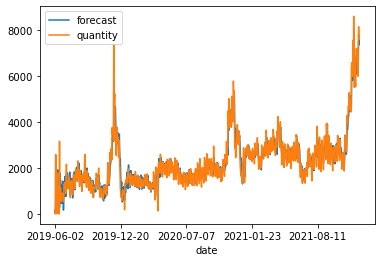

In [136]:
# fit model
model = ARIMA(df_train, order=(2,1,8))
results = model.fit()
results.plot_predict(dynamic=False)
plt.show()

In [117]:
prediction = results.forecast(30)

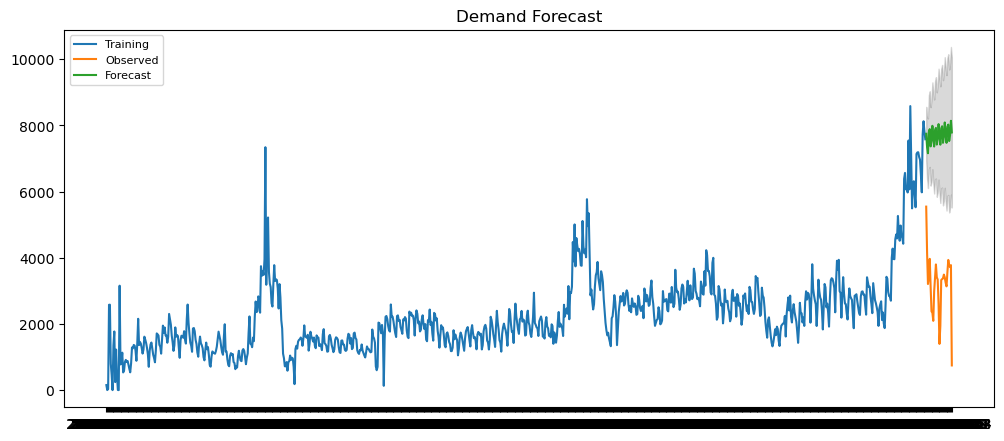

In [137]:
# Forecast
pred, se, conf = results.forecast(30, alpha=0.05)
Forecast = pd.Series(pred, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='Training')
plt.plot(df_test, label='Observed')
plt.plot(Forecast, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Demand Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

My interpretation of it is that this model is not reasonable to predict 30 days ahead for this kind of series, so I will try other models.

In [138]:
from sklearn.metrics import mean_absolute_error

In [139]:
mean_absolute_error(df_test, Forecast)

4507.4179911123265

# Auto-arima test

Attempted to model using auto_arima, but still the model did not capture the decrease in demand caracteristic of the series

In [73]:
from pmdarima.arima import auto_arima

In [74]:
arima_model = auto_arima(df_train)

In [75]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  928
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -6901.864
Date:                Mon, 17 Jan 2022   AIC                          13815.728
Time:                        14:22:07   BIC                          13844.720
Sample:                             0   HQIC                         13826.788
                                - 928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2432      0.003    430.302      0.000       1.238       1.249
ar.L2         -0.9977      0.001   -783.562      0.000      -1.000      -0.995
ma.L1         -1.7325      0.014   -121.299      0.000      -1.760      -1.704
ma.L2          1.5854      0.020     80.635      0.000       1.547       1.624
ma.L3         -0.4930      0.016    -30.808      0.000      -0.524      -0.462
sigma2      1.926e+05   3858.951     49.909      0.000    1.85e+05       2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              8545.78
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.15
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 30), index=df_test.index)
prediction.columns = ['Predicted Demand']

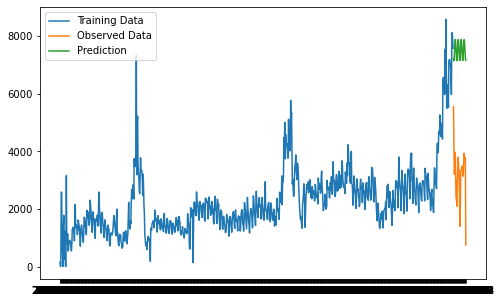